# Connect Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
project_path = "/content/drive/MyDrive/hair_segmentation"
os.chdir(project_path)
!pwd

Mounted at /content/drive
/content/drive/MyDrive/hair_segmentation


# Imports & Globals

In [ ]:
!pip install -U albumentations>=0.3.0 --user
!pip install git+https://github.com/qubvel/segmentation_models
# !pip install tensorflowjs

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

# Data Loader

In [4]:
import albumentations as A

def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [5]:
x_train_dir = os.path.join(project_path, 'train_imgs')
y_train_dir = os.path.join(project_path, 'train_masks')

x_valid_dir = os.path.join(project_path, 'validation_imgs')
y_valid_dir = os.path.join(project_path, 'validation_masks')

In [6]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id.replace('png', 'bmp')) for image_id in self.ids]

        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):

        image = cv2.imread(self.images_fps[i])
        mask_rgb = cv2.imread(self.masks_fps[i])

        if image is None or mask_rgb is None:
            return None

        image = cv2.resize(image, (320, 320))
        mask_rgb = cv2.resize(mask_rgb, (320, 320))

        # image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # mask
        mask_gray = cv2.cvtColor(mask_rgb, cv2.COLOR_BGR2GRAY)
        hair_mask = np.zeros_like(mask_gray)
        hair_mask[mask_gray == 255] = 255 # hair pixel value is 255
        mask = np.stack([hair_mask], axis=-1).astype('float')

        # print(image.shape, mask.shape)

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # print(image.shape, mask.shape)
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)   

In [ ]:
# Lets look at augmented data we have
dataset = Dataset(
    x_train_dir, y_train_dir, 
    # augmentation=get_training_augmentation()
)

image, mask = dataset[5]

# for i in range(3200):
#     print(i)
#     k = dataset[i]
#     if k is None:
#         print(i, 'NONE')

# print(image.shape, mask.shape)

# visualize(
#     image=image, 
#     hair_mask=mask[..., 0].squeeze(),
# )

In [7]:
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch_img = []
        batch_mask = []
        for d in data:
            image, mask = d
            batch_img.append(image)
            batch_mask.append(mask)
        
        batch = [np.stack(batch_img, axis=0), np.stack(batch_mask, axis=0)]

        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [8]:
import segmentation_models as sm

BACKBONE = 'mobilenetv2'
BATCH_SIZE = 8
# CLASSES = ['hair']
LR = 0.0001
EPOCHS = 40

preprocess_input = sm.get_preprocessing(BACKBONE)

# define network parameters
n_classes = 1 #if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' # if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# dice_loss = sm.losses.DiceLoss()
# focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
total_loss = sm.losses.binary_focal_dice_loss # or 
# total_loss = sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

Segmentation Models: using `keras` framework.


/usr/local/lib/python3.7/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    # augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# # Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir,
    # augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
# print(train_dataloader[0][0].shape, train_dataloader[0][1].shape, n_classes)
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=False, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [ ]:
# train model
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks,
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [12]:
test_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    # augmentation=get_training_augmentation(),
    # preprocessing=get_preprocessing(preprocess_input),
)

# test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [9]:
# load best weights
model.load_weights('best_model_1.h5')
# print('loaded model')
# scores = model.evaluate(test_dataloader)

# print("Loss: {:.5}".format(scores[0]))
# for metric, value in zip(metrics, scores[1:]):
#     print("mean {}: {:.5}".format(metric.__name__, value))

1/1 [==============================] - 1s 983ms/step


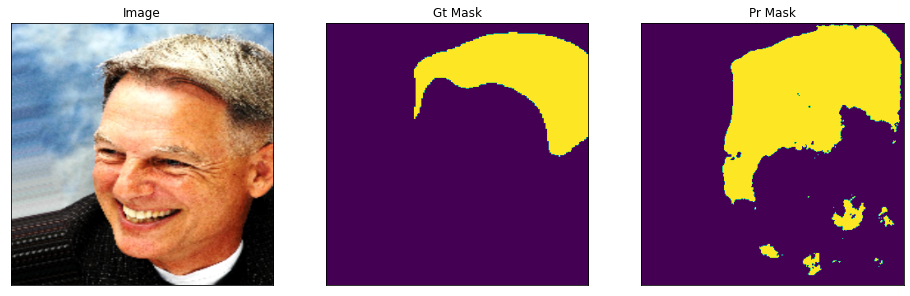

1/1 [==============================] - 0s 22ms/step


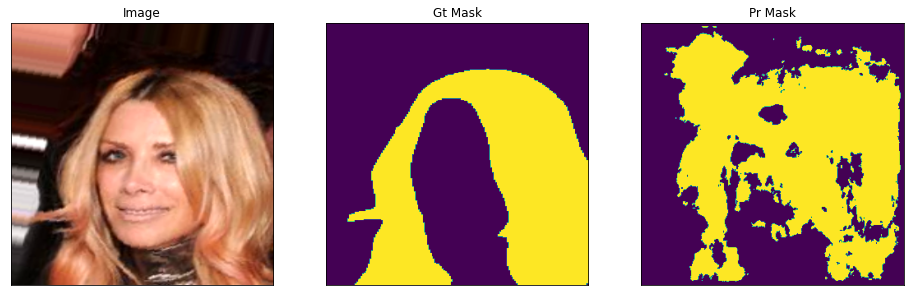

1/1 [==============================] - 0s 23ms/step


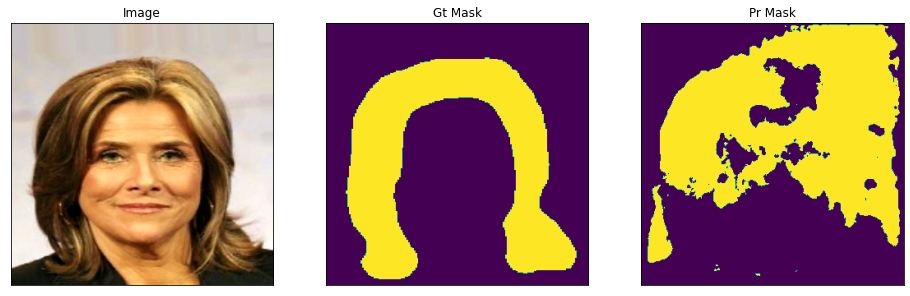

1/1 [==============================] - 0s 21ms/step


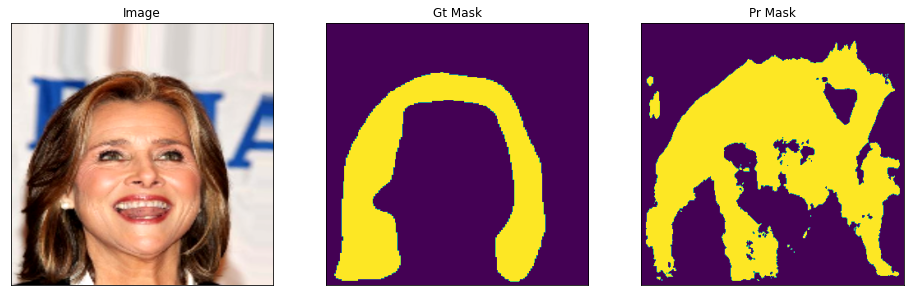

1/1 [==============================] - 0s 28ms/step


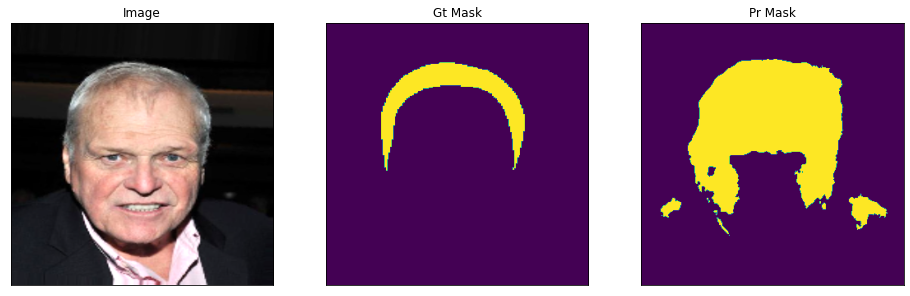

In [13]:
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )

In [ ]:
# import tensorflow as tf
# import segmentation_models as sm
# import tensorflowjs as tfjs

# def total_loss_Func():
#     dice_loss = sm.losses.DiceLoss()
#     focal_loss = sm.losses.BinaryFocalLoss()
#     return dice_loss + (1 * focal_loss)

# mdl = tf.keras.models.load_model('best_model_1.h5', custom_objects={
#     # 'binary_focal_loss_plus_dice_loss': sm.losses.binary_focal_dice_loss,
#     'dice_loss_plus_1binary_focal_loss': total_loss_Func,
#     'iou_score': sm.metrics.IOUScore,
#     'f1-score': sm.metrics.FScore
#     })
# converter = tf.lite.TFLiteConverter.from_keras_model(mdl)
# converter.experimental_new_converter = True
# tflite_model = converter.convert()
# open("best_model_1_2.tflite", "wb").write(tflite_model)

# tfjs.converters.save_keras_model(mdl, './models')

Segmentation Models: using `keras` framework.
